In [1]:
import setup
setup.init_django()
from market import services as market_services
from market import tasks as market_tasks
from market.models import Company
import json
from decouple import config

In [2]:
ticker = "GOOG"
name = "Google"
company, _ = Company.objects.get_or_create(name=name, ticker=ticker)
company.id

3

In [ ]:
market_tasks.sync_historical_stock_data(
    years_ago=1, 
    company_ids=[company.id], 
    use_celery=False, 
    verbose=True
)

# use celery / async
# market_tasks.sync_historical_stock_data.delay(years_ago=5, company_ids=[company.id], use_celery=True, verbose=False)

In [3]:
import pandas as pd
from market import services as market_services

# Assume `days` and `ticker` are already defined
days = 120
queryset = market_services.get_daily_stock_quotes_queryset(ticker, days=days)

# Extract relevant fields
historical_data_list = queryset.values(
    'time', 'open_price', 'close_price', 'high_price', 'low_price',
    'raw_timestamp', 'number_of_trades', 'volume', 'volume_weighted_average'
)

# Convert to DataFrame
historical_data = pd.DataFrame.from_records(historical_data_list)

# Convert 'time' to datetime and set as index
historical_data['time'] = pd.to_datetime(historical_data['time'])
historical_data.set_index('time', inplace=True)

# Keep only the 'close_price' column
historical_data = historical_data[['close_price']]

# Verify the structure
print(historical_data.head())


                          close_price
time                                 
2024-09-19 23:55:00+00:00    163.2765
2024-09-20 23:55:00+00:00    164.8100
2024-09-23 23:55:00+00:00    162.9000
2024-09-24 23:50:00+00:00    163.6500
2024-09-25 23:55:00+00:00    163.1640


In [4]:
print(historical_data.columns)


Index(['close_price'], dtype='object')


In [5]:
print(historical_data.head())
print(historical_data.dtypes)

                          close_price
time                                 
2024-09-19 23:55:00+00:00    163.2765
2024-09-20 23:55:00+00:00    164.8100
2024-09-23 23:55:00+00:00    162.9000
2024-09-24 23:50:00+00:00    163.6500
2024-09-25 23:55:00+00:00    163.1640
close_price    object
dtype: object


In [6]:
from merlion.models.forecast.deep_ar import DeepARForecaster, DeepARConfig
from merlion.utils import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
from merlion.models.forecast.deep_ar import DeepARForecaster

# Print the signature of the DeepARForecaster constructor
print(DeepARForecaster.__init__.__annotations__)


{'config': <class 'merlion.models.forecast.deep_ar.DeepARConfig'>}


In [8]:
print(historical_data.dtypes)

close_price    object
dtype: object


In [9]:
from merlion.models.forecast.deep_ar import DeepARForecaster, DeepARConfig
from merlion.utils import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt

historical_data.index = historical_data.index.tz_localize(None)

print("Missing values:", historical_data.isnull().sum())

historical_data.fillna(method="ffill", inplace=True)  # Forward fill
historical_data.fillna(method="bfill", inplace=True)  # Backward fill
historical_data.dropna(inplace=True)

time_series = TimeSeries.from_pd(historical_data)

print("Time series data:")
print(time_series.to_pd().head())
print("Time series shape:", time_series.to_pd().shape)


Missing values: close_price    0
dtype: int64
Time series data:
                     close_price
time                            
2024-09-19 23:55:00     163.2765
2024-09-20 23:55:00     164.8100
2024-09-23 23:55:00     162.9000
2024-09-24 23:50:00     163.6500
2024-09-25 23:55:00     163.1640
Time series shape: (95, 1)


/tmp/ipykernel_76876/872399467.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_data.fillna(method="ffill", inplace=True)  # Forward fill
/tmp/ipykernel_76876/872399467.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_data.fillna(method="bfill", inplace=True)  # Backward fill


In [10]:
config = DeepARConfig(
    n_past=7,              # Use the past 10 time steps as input
    max_forecast_steps=30,  # Forecast 30 steps into the future
    target_seq_index=0,     # Use the first column as the target (close_price)
    hidden_size=100,        # Number of hidden units in the LSTM
    num_layers=2,           # Number of LSTM layers
    learning_rate=0.0001,   # Learning rate for training
    batch_size=16           # Smaller batch size
)

model = DeepARForecaster(config=config)
train_result = model.train(time_series)
print("Training complete!")

 |========================================| 100.0% Train Loss:  0.3798, Validation Loss:  0.4407
Training complete!


In [11]:
last_timestamp = historical_data.index[-1]
future_timestamps = pd.date_range(start=last_timestamp, periods=31, freq="D")[1:]  # Exclude the last historical timestamp

# Make predictions
forecast, stderr = model.forecast(time_stamps=future_timestamps)

# Convert the forecast to a DataFrame for better readability
forecast_df = forecast.to_pd()
print(forecast_df)

                     close_price
time                            
2025-01-18 00:50:00   181.332966
2025-01-19 00:50:00   179.487199
2025-01-20 00:50:00   183.438660
2025-01-21 00:50:00   180.693149
2025-01-22 00:50:00   178.299544
2025-01-23 00:50:00   179.046681
2025-01-24 00:50:00   177.319628
2025-01-25 00:50:00   179.773677
2025-01-26 00:50:00   177.939762
2025-01-27 00:50:00   176.866452
2025-01-28 00:50:00   185.216447
2025-01-29 00:50:00   179.811205
2025-01-30 00:50:00   180.677640
2025-01-31 00:50:00   180.578592
2025-02-01 00:50:00   178.660963
2025-02-02 00:50:00   181.236453
2025-02-03 00:50:00   175.262400
2025-02-04 00:50:00   180.909491
2025-02-05 00:50:00   178.242107
2025-02-06 00:50:00   179.495495
2025-02-07 00:50:00   176.194879
2025-02-08 00:50:00   172.964446
2025-02-09 00:50:00   181.413094
2025-02-10 00:50:00   179.316056
2025-02-11 00:50:00   184.513190
2025-02-12 00:50:00   181.310059
2025-02-13 00:50:00   183.317343
2025-02-14 00:50:00   181.159924
2025-02-15

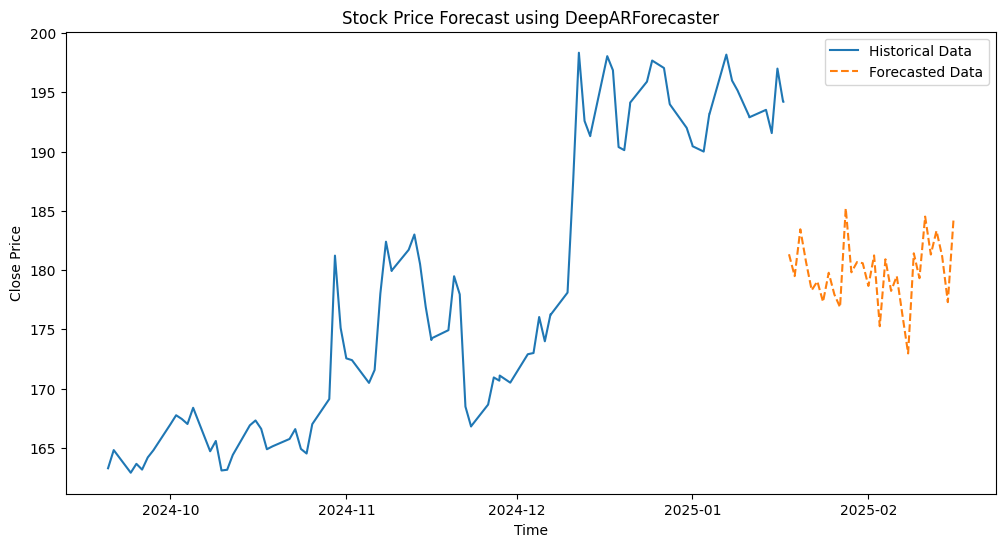

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data["close_price"], label="Historical Data")
plt.plot(forecast_df.index, forecast_df["close_price"], label="Forecasted Data", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("Stock Price Forecast using DeepARForecaster")
plt.legend()
plt.show()